#Cropify: Automated Irigation System


Total Water Used: 2509.5199999999995

Irrigation Path: [(0, 0), (0, 1), (1, 0), (0, 2), (1, 1), (2, 0), (0, 3), (1, 2), (2, 1), (3, 0), (0, 4), (1, 3), (2, 2), (3, 1), (4, 0), (0, 5), (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (0, 6), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (6, 0), (0, 7), (1, 6), (2, 5), (3, 4), (4, 3), (5, 2), (6, 1), (7, 0), (0, 8), (1, 7), (2, 6), (3, 5), (4, 4), (5, 3), (6, 2), (7, 1), (8, 0), (0, 9), (1, 8), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3), (7, 2), (8, 1), (9, 0), (0, 10), (1, 9), (2, 8), (3, 7), (4, 6), (5, 5), (6, 4), (7, 3), (8, 2), (9, 1), (10, 0), (0, 11), (1, 10), (2, 9), (3, 8), (4, 7), (5, 6), (6, 5), (7, 4), (8, 3), (9, 2), (10, 1), (11, 0), (0, 12), (1, 11), (2, 10), (3, 9), (4, 8), (5, 7), (6, 6), (7, 5), (8, 4), (9, 3), (10, 2), (11, 1), (12, 0), (0, 13), (1, 12), (2, 11), (3, 10), (4, 9), (5, 8), (6, 7), (7, 6), (8, 5), (9, 4), (10, 3), (11, 2), (12, 1), (13, 0), (0, 14), (1, 13), (2, 12), (3, 11), (4, 10), (5, 9), (6, 8), (7, 7), (8, 6), (9, 5)

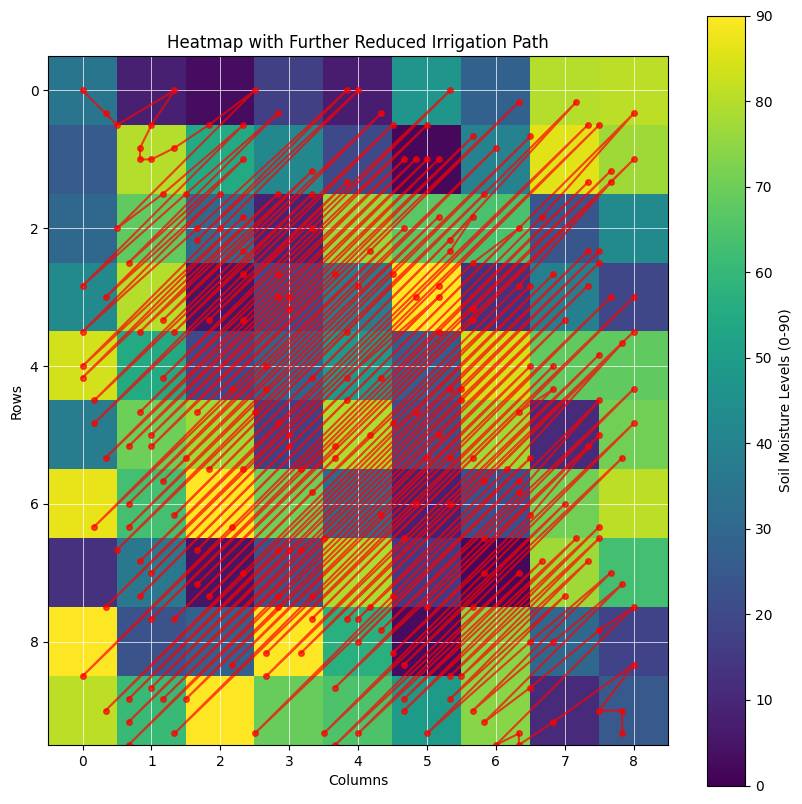

In [2]:
import pandas as pd
import numpy as np
import heapq
import matplotlib.pyplot as plt

# Load the dataset
file_path = "crop_dataset.csv"  # Update this with the correct file path
data = pd.read_csv(file_path)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # Randomize rows with a fixed seed for reproducibility

# Define the grid dimensions
num_columns = 50  # Adjust as needed
num_rows = (len(data) + num_columns - 1) // num_columns  # Calculate rows to fit the data

# Pad the dataset if needed
padding_needed = num_rows * num_columns - len(data)
if padding_needed > 0:
    padding = pd.DataFrame({'soil_moisture': [0.0] * padding_needed, 'water_need': [0.0] * padding_needed})
    data = pd.concat([data, padding], ignore_index=True)

# Reshape the dataset into grids
soil_moisture = data['soil_moisture'].values.reshape(num_rows, num_columns)
crop_needs = data['water_need'].values.reshape(num_rows, num_columns)

# Define the A* algorithm
def a_star(soil_moisture, crop_needs, start, water_limit):
    rows, cols = soil_moisture.shape
    visited = set()
    priority_queue = []
    heapq.heappush(priority_queue, (0, start, water_limit))  # (cost, position, remaining_water)
    irrigation_path = []
    total_water_used = 0
    epsilon = 1e-6  # Floating-point tolerance

    while priority_queue:
        cost, (x, y), current_water = heapq.heappop(priority_queue)

        if (x, y) in visited:
            continue

        visited.add((x, y))
        irrigation_path.append((x, y))

        # If we've reached the bottom-right corner, terminate
        if x == rows - 1 and y == cols - 1:
            break

        # Calculate water required for this cell
        water_needed = max(0.0, crop_needs[x][y] - soil_moisture[x][y])
        if soil_moisture[x][y] < 0.3 * crop_needs[x][y]:  # Threshold for prioritizing water allocation
            water_used = min(water_needed, current_water)  # Use only as much water as available
            soil_moisture[x][y] += water_used
            total_water_used += water_used
            current_water -= water_used

        # Add neighbors to the queue
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Up, Down, Left, Right
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and (nx, ny) not in visited:
                # Heuristic: shortest path + prioritize critical cells
                heuristic = abs(rows - 1 - nx) + abs(cols - 1 - ny)
                # Critical cells have a higher "need score" for priority
                need_score = max(0.0, crop_needs[nx][ny] - soil_moisture[nx][ny])
                movement_cost = heuristic + need_score * (1 - current_water / water_limit)
                heapq.heappush(priority_queue, (cost + movement_cost, (nx, ny), current_water))

    return soil_moisture, total_water_used, irrigation_path


# Starting position and water limit
start = (0, 0)  # Top-left corner
water_limit = 3000  # Adjust as needed

# Run A* Algorithm
updated_grid, total_water_used, irrigation_path = a_star(soil_moisture, crop_needs, start, water_limit)

# Results
print(f"\nTotal Water Used: {total_water_used}")
print(f"\nIrrigation Path: {irrigation_path}")

# Visualize the irrigation grid and path with further reduced points
def visualize_heatmap_with_reduced_path(grid, path, max_soil_moisture=90, path_reduction_factor=12):
    """
    Visualizes the soil moisture as a heatmap with reduced grid density and the irrigation path overlayed.
    Args:
        grid: The soil moisture grid.
        path: List of coordinates representing the irrigation path.
        max_soil_moisture: The maximum value for color scaling.
        path_reduction_factor: Factor to reduce the path points density.
    """
    # Reduce the density of the grid by skipping cells
    reduced_grid = grid[::6, ::6]  # Adjust this factor for further reduction

    # Plot the reduced density heatmap
    plt.figure(figsize=(10, 10))
    plt.imshow(reduced_grid, cmap='viridis', origin='upper', vmin=0, vmax=max_soil_moisture)
    plt.colorbar(label='Soil Moisture Levels (0-90)')

    # Reduce the path density even more by skipping more points
    reduced_path = path[::path_reduction_factor]

    # Plot the reduced irrigation path on the grid
    path_x, path_y = zip(*reduced_path)
    plt.plot(np.array(path_y) / 6, np.array(path_x) / 6, marker='o', color='red', markersize=4, linestyle='-', alpha=0.7)

    plt.title(f"Heatmap with Further Reduced Irrigation Path")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.grid(color='white', linestyle='-', linewidth=0.5)
    plt.show()

# Plot the heatmap with further reduced irrigation path points
visualize_heatmap_with_reduced_path(updated_grid, irrigation_path)